# Figures from Assessing Correlated Truncation Errors in Modern Nucleon-Nucleon Potentials

In [1]:
from cheftgp.eft import *
from cheftgp.gaussianprocess import *
from cheftgp.graphs import *
from cheftgp.scattering import *
from cheftgp.utils import *
from scripts.generator_fns import *
import scipy

In [2]:
mpl.rc(
        "savefig",
        transparent=False,
        bbox="tight",
        pad_inches=0.05,
        dpi=300,
        format="png",
    )

# Plot four-panel figures of total cross section ($\sigma_{\mathrm{tot}}$) coefficients

In [3]:
# sets colors
cmaps = [plt.get_cmap(name) for name in ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples']]
colors = [cmap(0.55 - 0.1 * (i==0)) for i, cmap in enumerate(cmaps)]

In [4]:
# gets data for potential
pot = 'RKE_L-500MeV'
    
def get_data(observable_string):
    file_name = 'scattering_observables_RKE_L-500MeV.h5'
    dir_path = '../observables_data/'
    full_path = dir_path + file_name
    response = h5py.File(full_path, "r")
    obs_data = np.array(response[observable_string][:])
    response.close()
    return obs_data

SGT = get_data('SGT').T
DSG = get_data('DSG')
AY = get_data('PB')
A = get_data('A')
D = get_data('D')
AXX = get_data('AXX')
AYY = get_data('AYY')
t_lab = get_data('t_lab')
degrees = get_data('degrees')

# sets orders
if pot[:3] == 'RKE':
    orders = np.array([0, 2, 3, 4, 5, 6])
else:
    orders = np.array([0, 2, 3, 4, 5])

# calculates relative momentum from lab energy
p_rel = E_to_p(t_lab, interaction = 'np')

#### $m_{\mathrm{eff}} = 138\,\mathrm{MeV}$, $\Lambda_{b} = 600\,\mathrm{MeV}$

#### Fig. 1

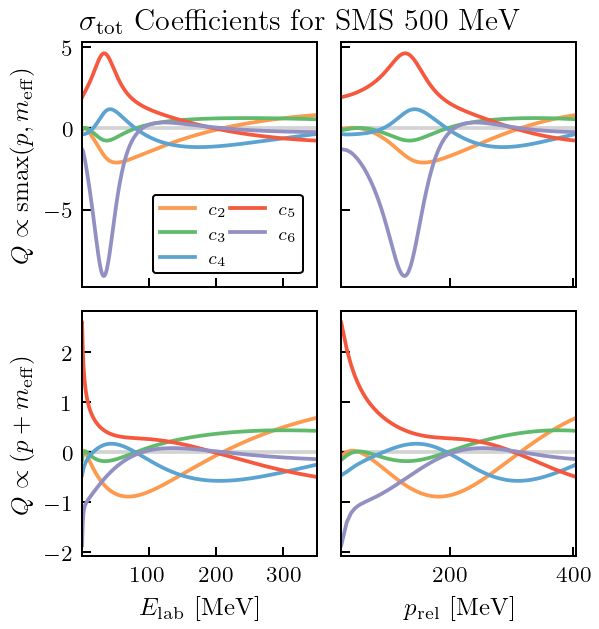

In [5]:
# sets breakdown and soft scales 
breakdown = 600
mpi = 138

# evaluates ratios
Q_max_p = Q_approx(p_rel, "smax", breakdown, m_pi = mpi)
Q_max_E = Q_approx(p_rel, "smax", breakdown, m_pi = mpi)
Q_s_p = Q_approx(p_rel, "sum", breakdown, m_pi = mpi)
Q_s_E = Q_approx(p_rel, "sum", breakdown, m_pi = mpi)
Q_list = [Q_max_E, Q_max_p, Q_s_E, Q_s_p]

# evaluates coefficients
coeffs_sgt_max_p = gm.coefficients(SGT, ratio=Q_max_p, ref=SGT[:, 0], orders=orders)[:, 1:]
coeffs_sgt_max_E = gm.coefficients(SGT, ratio=Q_max_E, ref=SGT[:, 0], orders=orders)[:, 1:]
coeffs_sgt_sum_p = gm.coefficients(SGT, ratio=Q_s_p, ref=SGT[:, 0], orders=orders)[:, 1:]
coeffs_sgt_sum_E = gm.coefficients(SGT, ratio=Q_s_E, ref=SGT[:, 0], orders=orders)[:, 1:]

coeffs_sgt = np.array([gm.coefficients(SGT, ratio=Q, ref=SGT[:, 0], orders=orders)[:, 1:] for Q in Q_list])

# plots
fig, axes = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(3.5,3.5))

for i, coeff in enumerate(np.swapaxes(np.swapaxes(coeffs_sgt, 0, 2), 1, 2)):
    axes[0, 0].plot(t_lab, coeff[0], color=colors[i], label=f'$c_{orders[i+1]}$')
    axes[1, 0].plot(t_lab, coeff[2], color=colors[i], label=f'$c_{orders[i+1]}$')
    axes[0, 1].plot(p_rel, coeff[1], color=colors[i], label=f'$c_{orders[i+1]}$')
    axes[1, 1].plot(p_rel, coeff[3], color=colors[i], label=f'$c_{orders[i+1]}$')

for ax in axes.ravel():
    ax.axhline(0, 0, 1, color='lightgrey', zorder=-1)
axes[0, 0].legend(loc = "lower right", fontsize = 7, ncol = 2, columnspacing = 0.2)
axes[1, 0].set_xlabel(r'$E_{\rm lab}$ [MeV]', fontsize = 10)
axes[1, 1].set_xlabel(r'$p_{\rm rel}$ [MeV]', fontsize = 10)
axes[0, 0].set_ylabel(f'$Q \propto \mathrm{{smax}}(p, m_{{\mathrm{{eff}}}})$', fontsize = 10)
axes[1, 0].set_ylabel(f'$Q \propto (p + m_{{\mathrm{{eff}}}})$', fontsize = 10)
fig.tight_layout()
fig.suptitle(r'$\sigma_{\mathrm{tot}}$ Coefficients for SMS 500 MeV', 
             y=1.01, 
             fontsize = 12)
# saves
fig.savefig(f'sgt_coeff_assumption_grid_{pot}_mpi{mpi}.png')

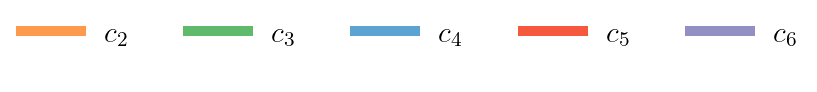

In [6]:
def export_legend(ax, filename="legend.png"):
    fig2 = plt.figure(figsize=(5, 0.5))
    ax2 = fig2.add_subplot()
    ax2.axis('off')
    legend = ax2.legend(*ax.get_legend_handles_labels(), 
                        frameon=False, loc='lower center', ncol=5, 
                       fontsize = 12)
    for i in range(5):
        legend.get_lines()[i].set_linewidth(4)
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)
export_legend(axes[0, 0])

#### Figs. 5a, 6a

In [3]:
generate_diagnostics(
#     nn_interaction="np",
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["SGT"],
#     E_input_array=[],
#     deg_input_array=[],
    x_quantities_array = [[], [0]],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["prel"]],
    train_test_split_array=[Allenergysplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
#     LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
    fixed_sd=None,
    m_pi_eff=138,
    Lambdab=600,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=True,
    plot_plotzilla_bool=False,
    save_coeffs_bool=False,
    save_md_bool=False,
    save_pc_bool=False,
    save_ci_bool=False,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_mpi138",
)

[[], [0]]
[None, [0]]
[[None 0]]
E_lab = [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 2

IndexError: boolean index did not match indexed array along dimension 0; dimension is 6 but corresponding boolean dimension is 2100

#### $m_{\mathrm{eff}} = 200\,\mathrm{MeV}$, $\Lambda_{b} = 600\,\mathrm{MeV}$

#### Fig. 3

In [ ]:
# sets breakdown and soft scales 
breakdown = 600
mpi = 200

# evaluates ratios
Q_max_p = Q_approx(p_rel, "smax", breakdown, m_pi = mpi)
Q_max_E = Q_approx(p_rel, "smax", breakdown, m_pi = mpi)
Q_s_p = Q_approx(p_rel, "sum", breakdown, m_pi = mpi)
Q_s_E = Q_approx(p_rel, "sum", breakdown, m_pi = mpi)
Q_list = [Q_max_E, Q_max_p, Q_s_E, Q_s_p]

# evaluates coefficients
coeffs_sgt_max_p = gm.coefficients(SGT, ratio=Q_max_p, ref=SGT[:, 0], orders=orders)[:, 1:]
coeffs_sgt_max_E = gm.coefficients(SGT, ratio=Q_max_E, ref=SGT[:, 0], orders=orders)[:, 1:]
coeffs_sgt_sum_p = gm.coefficients(SGT, ratio=Q_s_p, ref=SGT[:, 0], orders=orders)[:, 1:]
coeffs_sgt_sum_E = gm.coefficients(SGT, ratio=Q_s_E, ref=SGT[:, 0], orders=orders)[:, 1:]

coeffs_sgt = np.array([gm.coefficients(SGT, ratio=Q, ref=SGT[:, 0], orders=orders)[:, 1:] for Q in Q_list])

# plots
fig, axes = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(3.5,3.5))

for i, coeff in enumerate(np.swapaxes(np.swapaxes(coeffs_sgt, 0, 2), 1, 2)):
    axes[0, 0].plot(t_lab, coeff[0], color=colors[i], label=f'$c_{orders[i+1]}$')
    axes[1, 0].plot(t_lab, coeff[2], color=colors[i], label=f'$c_{orders[i+1]}$')
    axes[0, 1].plot(p_rel, coeff[1], color=colors[i], label=f'$c_{orders[i+1]}$')
    axes[1, 1].plot(p_rel, coeff[3], color=colors[i], label=f'$c_{orders[i+1]}$')

for ax in axes.ravel():
    ax.axhline(0, 0, 1, color='lightgrey', zorder=-1)
axes[0, 0].legend(loc = "lower right", fontsize = 7, ncol = 2, columnspacing = 0.2)
axes[1, 0].set_xlabel(r'$E_{\rm lab}$ [MeV]', fontsize = 10)
axes[1, 1].set_xlabel(r'$p_{\rm rel}$ [MeV]', fontsize = 10)
axes[0, 0].set_ylabel(f'$Q \propto \mathrm{{smax}}(p, m_{{\mathrm{{eff}}}})$', fontsize = 10)
axes[1, 0].set_ylabel(f'$Q \propto (p + m_{{\mathrm{{eff}}}})$', fontsize = 10)
fig.tight_layout()
fig.suptitle(r'$\sigma_{\mathrm{tot}}$ Coefficients for SMS 500 MeV', 
             y=1.01, 
             fontsize = 12)
# saves
fig.savefig(f'sgt_coeff_assumption_grid_{pot}_mpi{mpi}.png')

#### Figs. 5b, 6b

In [ ]:
generate_diagnostics(
#     nn_interaction="np",
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["SGT"],
#     E_input_array=[],
#     deg_input_array=[],
    x_quantities_array = [[], [0]],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["prel"]],
    train_test_split_array=[Allenergysplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
#     LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
    fixed_sd=None,
    m_pi_eff=200,
    Lambdab=600,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=True,
    plot_plotzilla_bool=False,
    save_coeffs_bool=False,
    save_md_bool=False,
    save_pc_bool=False,
    save_ci_bool=False,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_mpi200",
)

In [ ]:
1/0

#### $m_{\mathrm{eff}}$ and $\Lambda_{b}$ set to optimal values (see code)

#### Fig. 8

In [ ]:
# evaluates ratios with optimal values of breakdown and soft scale for each combination of 
# Q parametrization and input space
# Q_max_E = Q_approx(p_rel, "smax", 460, m_pi = 158)
# Q_max_p = Q_approx(p_rel, "smax", 377, m_pi = 106)
# Q_s_E = Q_approx(p_rel, "sum", 517, m_pi = 189)
# Q_s_p = Q_approx(p_rel, "sum", 477, m_pi = 141)
# Q_list = [Q_max_E, Q_max_p, Q_s_E, Q_s_p]
# Q_max_E = Q_approx(p_rel, "smax", 760, m_pi = 240)
Q_max_E = Q_approx(p_rel, "smax", 670, m_pi = 250)
Q_max_p = Q_approx(p_rel, "smax", 670, m_pi = 250)
# Q_s_E = Q_approx(p_rel, "sum", 1500, m_pi = 450)
Q_s_E = Q_approx(p_rel, "sum", 990, m_pi = 350)
Q_s_p = Q_approx(p_rel, "sum", 990, m_pi = 350)
Q_list = [Q_max_E, Q_max_p, Q_s_E, Q_s_p]

# evaluates coefficients
coeffs_sgt_max_p = gm.coefficients(SGT, ratio=Q_max_p, ref=SGT[:, 0], orders=orders)[:, 1:]
coeffs_sgt_max_E = gm.coefficients(SGT, ratio=Q_max_E, ref=SGT[:, 0], orders=orders)[:, 1:]
coeffs_sgt_sum_p = gm.coefficients(SGT, ratio=Q_s_p, ref=SGT[:, 0], orders=orders)[:, 1:]
coeffs_sgt_sum_E = gm.coefficients(SGT, ratio=Q_s_E, ref=SGT[:, 0], orders=orders)[:, 1:]

coeffs_sgt = np.array([gm.coefficients(SGT, ratio=Q, ref=SGT[:, 0], orders=orders)[:, 1:] for Q in Q_list])

# plots
fig, axes = plt.subplots(2, 2, 
                         sharex='col', 
                         sharey='row', 
                         figsize=(3.7,3.7))

for i, coeff in enumerate(np.swapaxes(np.swapaxes(coeffs_sgt, 0, 2), 1, 2)):
    axes[0, 0].plot(t_lab, coeff[0], color=colors[i], label=f'$c_{orders[i+1]}$')
    axes[1, 0].plot(t_lab, coeff[2], color=colors[i], label=f'$c_{orders[i+1]}$')
    axes[0, 1].plot(p_rel, coeff[1], color=colors[i], label=f'$c_{orders[i+1]}$')
    axes[1, 1].plot(p_rel, coeff[3], color=colors[i], label=f'$c_{orders[i+1]}$')

for ax in axes.ravel():
    ax.axhline(0, 0, 1, color='lightgrey', zorder=-1)
axes[0, 0].legend(loc = "lower right", fontsize = 7, ncol = 2, columnspacing = 0.2)
axes[1, 0].set_xlabel(r'$E_{\rm lab}$ [MeV]', fontsize = 10)
axes[1, 1].set_xlabel(r'$p_{\rm rel}$ [MeV]', fontsize = 10)
axes[0, 0].set_ylabel(f'$Q \propto \mathrm{{smax}}(p, m_{{\mathrm{{eff}}}})$', fontsize = 10)
axes[1, 0].set_ylabel(f'$Q \propto (p + m_{{\mathrm{{eff}}}})$', fontsize = 10)
fig.tight_layout()
fig.suptitle(fr'$\sigma_{{\mathrm{{tot}}}}$ Coefficients for SMS 500 MeV', 
             y=1.01, fontsize = 12)
# saves
fig.savefig(f'sgt_coeff_assumption_grid_{pot}_mpiopt.png')

## Plot for all $Q$ prescriptions against $p_{\rm rel}$

#### Fig. 2

In [ ]:
Elab_array = np.linspace(0, 350, 351)

fig, ax = plt.subplots(figsize = (5.1, 3.8))

Lambdab = 600

ax.plot(E_to_p(Elab_array, 'np'), Q_approx(E_to_p(Elab_array, "np"), "max", Lambda_b=Lambdab, m_pi = 138), 
        c = 'red', label = "max")
ax.plot(E_to_p(Elab_array, 'np'), Q_approx(E_to_p(Elab_array, "np"), "smax", Lambda_b=Lambdab, m_pi = 138), 
        c = 'green', label = "smoothmax")
# ax.plot(E_to_p(Elab_array, 'np'), Q_approx(E_to_p(Elab_array, "np"), "rawsum", Lambda_b=Lambdab, m_pi = 138), 
#         c = 'blue', label = r'sum (unscaled)', ls='--')
# ax.plot(E_to_p(Elab_array, 'np'), Q_approx(E_to_p(Elab_array, "np"), "sum", Lambda_b=Lambdab, m_pi = 138), 
#         c = 'blue', label = r'sum (scaled)')
ax.plot(E_to_p(Elab_array, 'np'), Q_approx(E_to_p(Elab_array, "np"), "sum", Lambda_b=Lambdab, m_pi = 138), 
        c = 'blue', label = r'sum')

axis_font = {'size':'13'}
ax.set_xlabel(r'$p_{\mathrm{rel}}$ [MeV]', **axis_font)
ax.set_ylabel(r'$Q$', **axis_font)
ax.set_ylim(0, 1)
ax.tick_params(axis='both', which='major', labelsize=11)
ax.legend(loc = 'upper left', prop={'size': 12}, ncol = 1, columnspacing = 0.2)
fig.tight_layout()
fig.savefig('figures/Qparamvsprel.png')

## Evaluates the ratio $Q_{\rm sum} / Q_{\rm smax}$ over the relevant range in momentum and compares to a linear fit function

In [ ]:
def Qcomparison(prel, Lambda_b, mpi):
    return scipy.integrate.trapz(
            Q_approx(prel, "sum", 
                Lambda_b, 
                m_pi = mpi, 
                single_expansion = False), prel) / \
        scipy.integrate.trapz(
            Q_approx(prel, "smax", 
                Lambda_b, 
                m_pi = mpi, 
                single_expansion = False), prel)
            

Elab_array = np.linspace(1, 350, 350)
prel_array = E_to_p(Elab_array, 'np')
mpi_array = np.linspace(50, 350, 301)
mpi_array = mpi_array[mpi_array >= 100]

fig, ax = plt.subplots(figsize = (5.1, 3.8))

Lambdab = 600

ax.plot(mpi_array, [Qcomparison(prel_array, Lambdab, m) for m in mpi_array], 
        c = 'blue', label = r'$Q_{\mathrm{sum}}/Q_{\mathrm{smax}}$')
# ax.plot(mpi_array, Qsum_to_Qsmoothmax(mpi_array), 
#         c = 'orange', label = 'fitted')
ax.plot(mpi_array, 
        np.average([Qcomparison(prel_array, Lambdab, m) for m in mpi_array]) * np.ones(len(mpi_array)), 
        c = 'red', linestyle = (5, (10, 3)), label = r'average')
# ax.plot(mpi_array, 
#         1.6 * np.ones(len(mpi_array)), 
#         c = 'red', linestyle = (5, (10, 3)), label = r'$a_{\mathrm{sum}}$')

axis_font = {'size':'18'}
ax.set_xlabel(r'$m_{\mathrm{eff}}$ [MeV]', **axis_font)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc = 'lower right', prop={'size': 16}, ncol = 1, columnspacing = 0.2)
fig.tight_layout()
fig.savefig('figures/QsumQsmax.png')

## Plots $Q$ as a constant at different slices in momentum and fits to linear curve

#### Fig. 7

In [ ]:
# fixed values of relative momentum where fitting will take place
Elab_fit_pts = np.array([1, 5, 12, 21, 
                         33, 48, 65, 85, 
                         108, 133, 161, 192, 
                         225, 261, 300, 341])
prel_fit_pts = E_to_p(E_lab = Elab_fit_pts, interaction = "np")

# creates every object necessary to evaluate Q posteriors curvewise at fixed momentum
ls_deg_vals = np.linspace(0.01, 4, 100, dtype=np.dtype('f4'))
q_vals = np.linspace(0.01, 1.01, 100, dtype=np.dtype('f4'))

mesh_cart_q = gm.cartesian(q_vals, np.log(ls_deg_vals))

QVariable = RandomVariable(var=q_vals,
                                user_val=0.3,
                                name='Q',
                                label="Q",
                                units="",
                                ticks=[0.2, 0.4, 0.6, 0.8],
                                logprior=np.zeros(len(q_vals)),
                                logprior_name="noprior",
                                marg_bool=True)
LsDegVariable = RandomVariable(var=ls_deg_vals,
                               user_val=None,
                               name='lsdeg',
                               label="\ell_{\Theta}",
                               units="",
                               ticks=[],
                               logprior=np.zeros(len(ls_deg_vals)),
                               logprior_name="noprior",
                               marg_bool=False)
variables_array = np.array([QVariable, LsDegVariable])

# ALLOBS for angle input spaces
plot_obs_list = [["DSG", "D", "AXX", "AYY", "A", "AY"]]
obs_name_grouped_list = ["ALLOBS"]
obs_labels_grouped_list = [r'Obs.']
mesh_cart_grouped_list = [[mesh_cart_q, mesh_cart_q, mesh_cart_q, mesh_cart_q,
                           mesh_cart_q, mesh_cart_q]]

ratio_fn = ratio_fn_posterior_const
ratio_fn_kwargs = {
                  "Q" : 0.3
}
log_likelihood_fn = log_likelihood_const
log_likelihood_fn_kwargs = {}

Q_fit_pts = np.array([])
Q_fit_stddev = np.array([])

for elfp in Elab_fit_pts:
    stats_array, _ = generate_posteriors(
#         nn_interaction="np",
        scale_scheme_bunch_array=[RKE500MeV],
        Q_param_method_array=["sum"],
        p_param_method_array=["pprel"],
        input_space_deg=["cos"],
        input_space_tlab=["prel"],
        Elab_slice = elfp,
        t_lab_train_pts=np.array([1, 12, 33, 65, 108, 161, 225, 300]),
        degrees_train_pts=np.array([41, 60, 76, 90, 104, 120, 139]),
        orders_from_ho=1,
        orders_excluded=[],
        orders_names_dict=None,
        orders_labels_dict=None,
        LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
        LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
        m_pi_eff=141,
        Lambdab=480,
        print_all_classes=False,
        savefile_type="png",

        plot_posterior_curvewise_bool=True,
        plot_corner_curvewise_bool=False,
        use_data_curvewise_bool=False,
        save_data_curvewise_bool=False,
        save_posterior_curvewise_bool=False,

        plot_obs_list = plot_obs_list,
        obs_name_grouped_list = obs_name_grouped_list,
        obs_labels_grouped_list = obs_labels_grouped_list,
        mesh_cart_grouped_list = mesh_cart_grouped_list,
        variables_array_curvewise = variables_array,
        
        ratio_fn_posterior = ratio_fn,
        ratio_fn_kwargs_posterior = ratio_fn_kwargs,
        log_likelihood_fn_posterior = log_likelihood_fn,
        log_likelihood_fn_kwargs_posterior = log_likelihood_fn_kwargs,

        plot_posterior_pointwise_bool=False,
        save_posterior_pointwise_bool=False,

        variables_array_pointwise = np.array([0]),

        filename_addendum="",
    )
    
    Q_fit_pts = np.append(Q_fit_pts, stats_array[0])
    Q_fit_stddev = np.append(Q_fit_stddev, stats_array[2])

In [ ]:
from sklearn.linear_model import LinearRegression

fig_fit, ax_fit = plt.subplots(figsize=(3.5,3.5))

def q_sum(x, lambda_b, m_pi):
    return (x + m_pi) / (m_pi + lambda_b)

# scatter-plots the means and 95% (2 sigma) confidence intervals for the N4LO+ Q posterior pdfs
ax_fit.errorbar(prel_fit_pts, Q_fit_pts, yerr = 2 * Q_fit_stddev,
                color = 'tab:purple', label = r'$Q$ (pointwise)', fmt = 'o')
# fits the points to a line
popt, pcov = scipy.optimize.curve_fit(q_sum, prel_fit_pts, Q_fit_pts, 
                                     sigma = Q_fit_stddev)
# plots the line of best fit
ax_fit.plot(E_to_p(E_lab = t_lab, interaction = 'np'), 
            q_sum(E_to_p(E_lab = t_lab, interaction = 'np'), popt[0], popt[1]), 
            color = 'tab:purple')
# prints the best fit values
print("N4LO+: Lambda_b = " + str(popt[0]) + " +/- " + str(np.sqrt(pcov[0, 0])) + " MeV")
print("N4LO+: m_eff = " + str(popt[1]) + " +/- " + str(np.sqrt(pcov[1, 1])) + " MeV\n")

# plots Qsum(prel) with Lambda_b and m_pi values extracted from the total cross section posterior pdf
ax_fit.plot(E_to_p(E_lab = t_lab, interaction = 'np'), 
           Q_approx(p = E_to_p(E_lab = t_lab, interaction = 'np'), 
                   Q_parametrization = 'sum', 
                    Lambda_b = 990, 
                    m_pi = 350), 
            color = 'orange', label = r'$\sigma_{\mathrm{tot}}$')
# plots Qsum(prel) with Lambda_b and m_pi values extracted from all the 2D observables' posterior pdf
ax_fit.plot(E_to_p(E_lab = t_lab, interaction = 'np'), 
           Q_approx(p = E_to_p(E_lab = t_lab, interaction = 'np'), 
                   Q_parametrization = 'sum', 
                    Lambda_b = 570, 
                    m_pi = 138), 
            color = 'green', label = r'All 2D observables')

# fig_fit.suptitle("MAP $Q$ values and lines of fit", fontsize = 20)
ax_fit.set_xlabel("$p_{\mathrm{rel}}$ [MeV]", fontsize = 12)
ax_fit.set_ylabel(r"$Q_{\mathrm{sum}}$", fontsize = 12)
ax_fit.legend(fontsize = 10, loc = 'upper left')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
fig_fit.tight_layout()

fig_fit.savefig('figures/' + 'qvsp_linear')

## Plots graphical and statistical diagnostics for all figures in the paper

#### Fig. 10

[[], [60]]
[None, [60]]
[[None 60]]
E_lab = [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 23

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:664: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optima = np.array(optima)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


self.ls_true = [48.75267858]
self.X_test has shape (10, 1)
self.underlying_std = 0.5841761919890589
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)


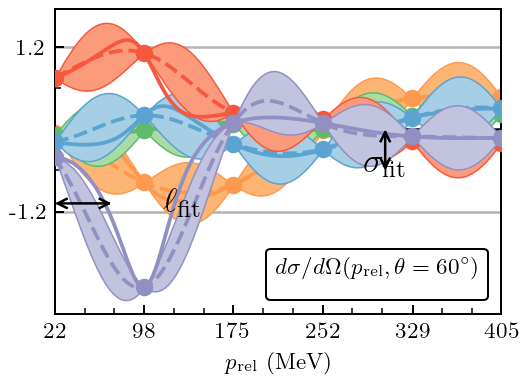

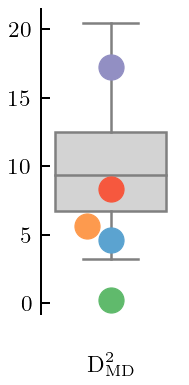

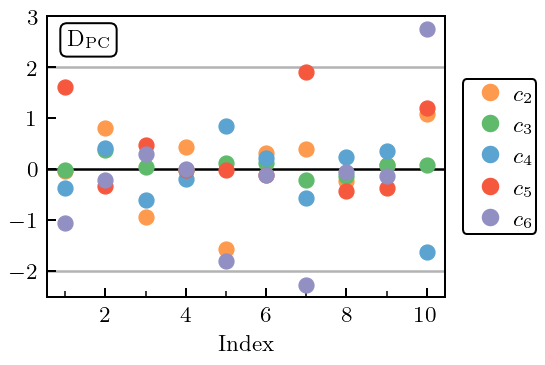

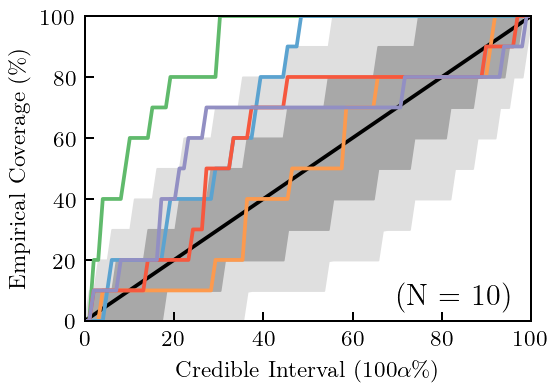

In [3]:
generate_diagnostics(
#     nn_interaction="np",
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["DSG"],
#     E_input_array=[],
#     deg_input_array=[60],
    x_quantities_array = [[], [60]],
    Q_param_method_array=["smax"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["prel"]],
    train_test_split_array=[Allenergysplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    # length_scale_input=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
    LengthScale_list = [LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
    fixed_sd=None,
    m_pi_eff=106,
    Lambdab=378,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=False,
    save_md_bool=False,
    save_pc_bool=False,
    save_ci_bool=False,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_paper_0",
)

#### Fig. 11

[[], [60]]
[None, [60]]
[[None 60]]
E_lab = [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 23

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:664: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optima = np.array(optima)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


self.ls_true = [90.43571803]
self.X_test has shape (10, 1)
self.underlying_std = 0.8807904294657384
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)


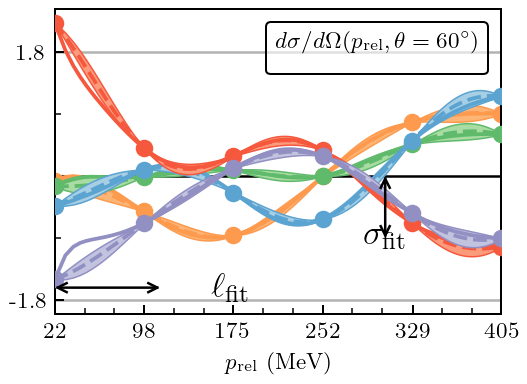

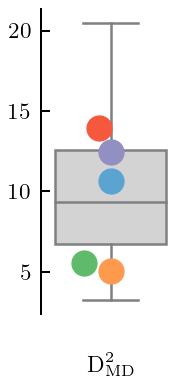

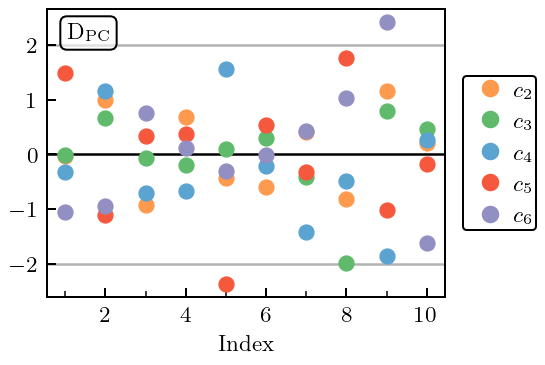

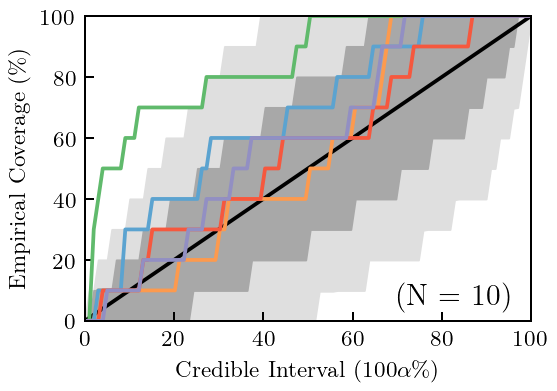

In [4]:
generate_diagnostics(
#     nn_interaction="np",
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["DSG"],
#     E_input_array=[],
#     deg_input_array=[60],
    x_quantities_array = [[], [60]],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["prel"]],
    train_test_split_array=[Allenergysplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    # length_scale_input=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
    LengthScale_list = [LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
    fixed_sd=None,
    m_pi_eff=138,
    Lambdab=570,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=False,
    save_md_bool=False,
    save_pc_bool=False,
    save_ci_bool=False,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_paper_0",
)

#### Figs. 28, 26a

[[150], []]
[[150], None]
[[150 None]]
E_lab = [150]
angle_lab = [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179]
['$', 'd \\sigma / d \\Omega', '(-\\mathrm{cos}(\\theta), E_{\\mathrm{lab}}= ', 150, '\\,\\mathrm{MeV})$']
(179,)
[-9.99847695e-01 -9.99390827e-01 -9.98629535e-01 -9.97564050e-01
 -9.96194698e-01 -9.94521895e

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:664: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optima = np.array(optima)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


self.ls_true = [0.27755035]
self.X_test has shape (10, 1)
self.underlying_std = 0.5478997480119223
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)


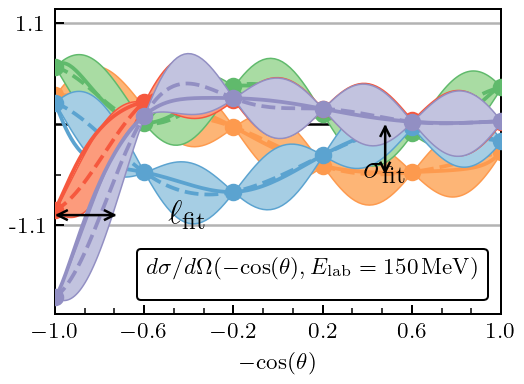

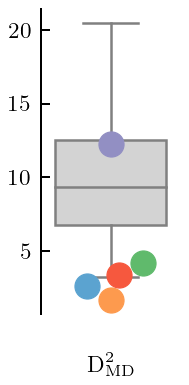

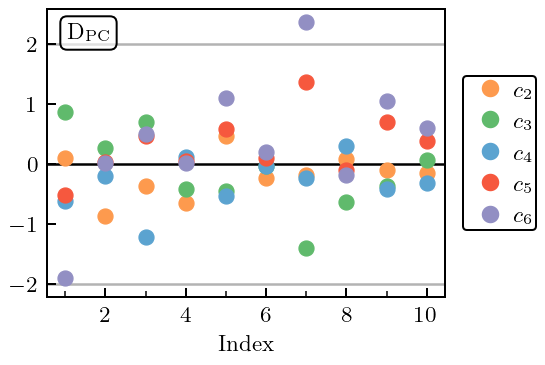

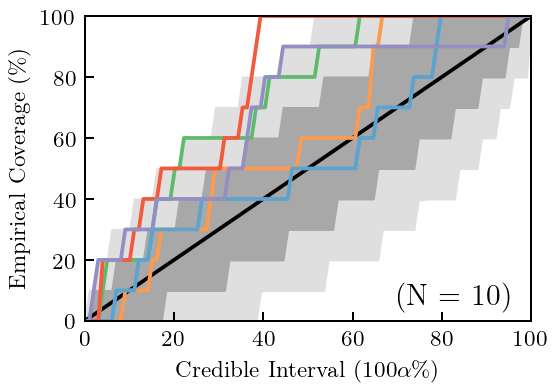

In [5]:
generate_diagnostics(
#     nn_interaction="np",
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["DSG"],
#     E_input_array=[150],
#     deg_input_array=[],
    x_quantities_array = [[150], []],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofpq"],
    input_space_input=[["cos"]],
    train_test_split_array=[Fullspaceanglessplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    # length_scale_input=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
    LengthScale_list = [LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
    fixed_sd=None,
    m_pi_eff=172,
    Lambdab=660,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=False,
    save_md_bool=False,
    save_pc_bool=False,
    save_ci_bool=False,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_paper_0",
)

#### Figs. 12, 26b

[[150], []]
[[150], None]
[[150 None]]
E_lab = [150]
angle_lab = [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179]
['$', 'd \\sigma / d \\Omega', '(-\\mathrm{cos}(\\theta), E_{\\mathrm{lab}}= ', 150, '\\,\\mathrm{MeV})$']
(179,)
[-9.99847695e-01 -9.99390827e-01 -9.98629535e-01 -9.97564050e-01
 -9.96194698e-01 -9.94521895e

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:664: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optima = np.array(optima)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


self.ls_true = [0.32326906]
self.X_test has shape (10, 1)
self.underlying_std = 0.6252413018856878
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)


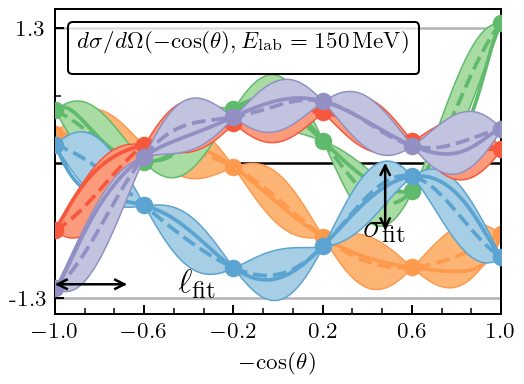

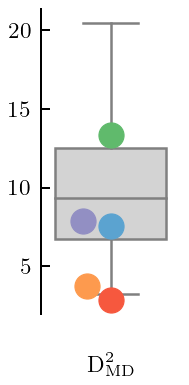

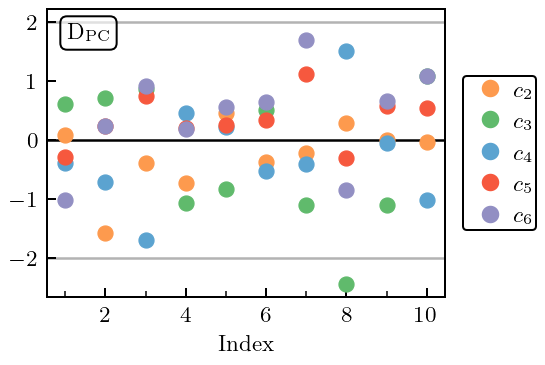

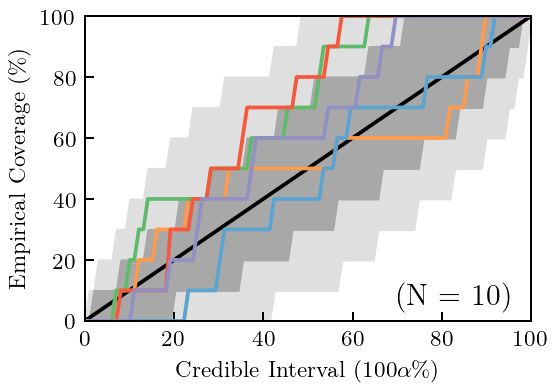

In [6]:
generate_diagnostics(
#     nn_interaction="np",
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["DSG"],
#     E_input_array=[150],
#     deg_input_array=[],
    x_quantities_array = [[150], []],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["cos"]],
    train_test_split_array=[Fullspaceanglessplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    # length_scale_input=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
    LengthScale_list = [LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
    fixed_sd=None,
    m_pi_eff=138,
    Lambdab=570,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=False,
    save_md_bool=False,
    save_pc_bool=False,
    save_ci_bool=False,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_paper_0",
)

#### Fig. 14

[[150], []]
[[150], None]
[[150 None]]
E_lab = [150]
angle_lab = [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179]
['$', 'D', '(q_{\\mathrm{cm}}, E_{\\mathrm{lab}}= ', 150, '\\,\\mathrm{MeV})$']
(179, 1)
[[  4.62984859]
 [  9.25934459]
 [ 13.88813547]
 [ 18.5158687 ]
 [ 23.14219188]
 [ 27.7667527 ]
 [ 32.38919897]
 [ 37.0

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:664: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optima = np.array(optima)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


self.ls_true = [102.43676924]
self.X_test has shape (10, 1)
self.underlying_std = 0.96549085535756
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)


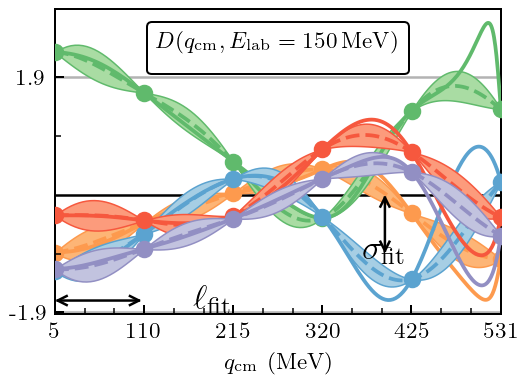

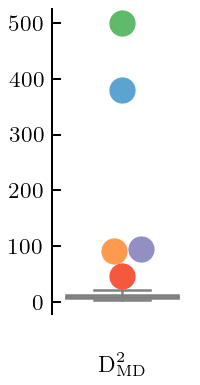

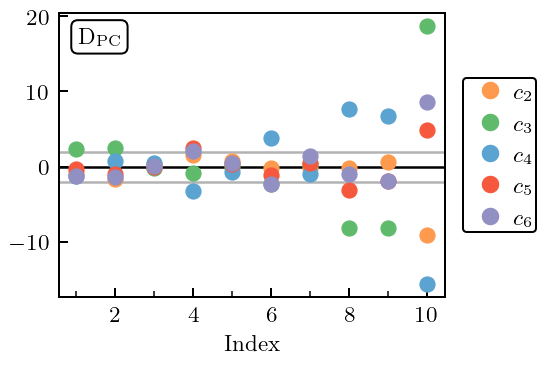

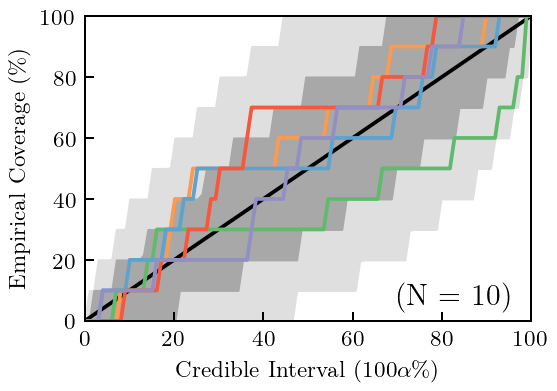

In [7]:
generate_diagnostics(
#     nn_interaction="np",
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["D"],
#     E_input_array=[150],
#     deg_input_array=[],
    x_quantities_array = [[150], []],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["qcm"]],
    train_test_split_array=[Fullspaceanglessplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    # length_scale_input=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
    LengthScale_list = [LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
    fixed_sd=None,
    m_pi_eff=184,
    Lambdab=650,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=False,
    save_md_bool=False,
    save_pc_bool=False,
    save_ci_bool=False,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_paper_0",
)

#### Fig. 13

[[150], []]
[[150], None]
[[150 None]]
E_lab = [150]
angle_lab = [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179]
['$', 'D', '(-\\mathrm{cos}(\\theta), E_{\\mathrm{lab}}= ', 150, '\\,\\mathrm{MeV})$']
(179,)
[-9.99847695e-01 -9.99390827e-01 -9.98629535e-01 -9.97564050e-01
 -9.96194698e-01 -9.94521895e-01 -9.92546152e-01 

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:664: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optima = np.array(optima)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


self.ls_true = [0.38051503]
self.X_test has shape (10, 1)
self.underlying_std = 0.8785272582563112
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)


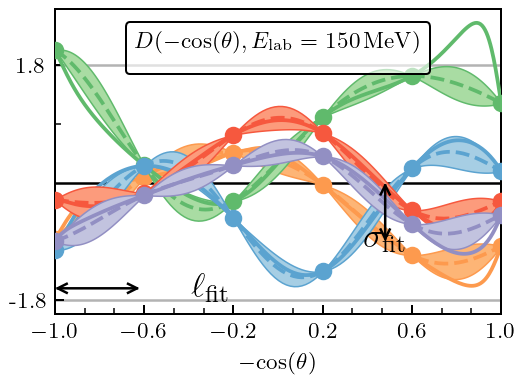

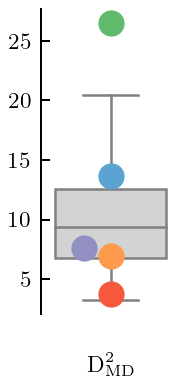

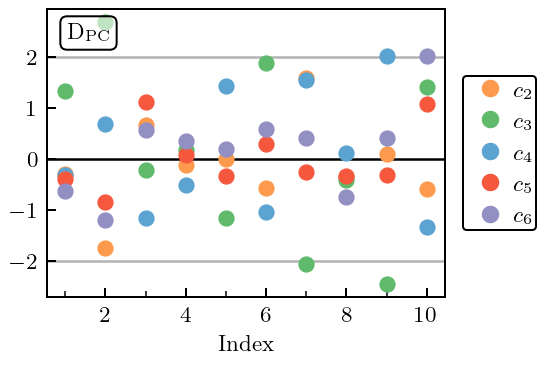

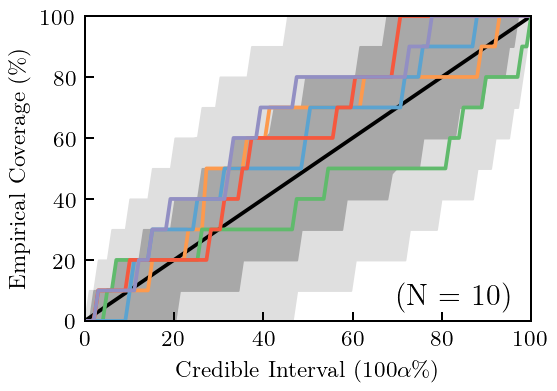

In [8]:
generate_diagnostics(
#     nn_interaction="np",
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["D"],
#     E_input_array=[150],
#     deg_input_array=[],
    x_quantities_array = [[150], []],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["cos"]],
    train_test_split_array=[Fullspaceanglessplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    # length_scale_input=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
    LengthScale_list = [LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
    fixed_sd=None,
    m_pi_eff=138,
    Lambdab=570,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=False,
    save_md_bool=False,
    save_pc_bool=False,
    save_ci_bool=False,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_paper_0",
)

#### Figs. 16, 27a

[[], [60]]
[None, [60]]
[[None 60]]
E_lab = [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 23

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:664: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optima = np.array(optima)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
c:\users\pjmil\research\modern_nn_potentials\cheftgp\gaussianprocess.py:1595: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.shape(np.array(self.x_quantity_array)[
c:\users\pjmil\research\modern_nn_potentials\cheftgp\gaussianprocess.py:

self.ls_true = [75.67282446]
self.X_test has shape (10, 1)
self.underlying_std = 0.529166099807505
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)


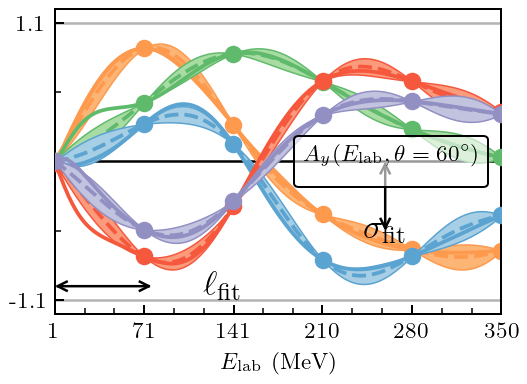

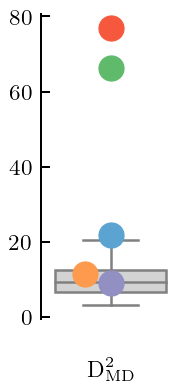

c:\users\pjmil\research\modern_nn_potentials\cheftgp\gaussianprocess.py:1790: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.shape(np.array(self.x_quantity_array)[


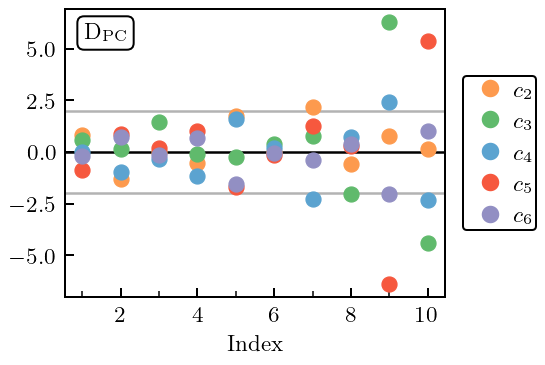

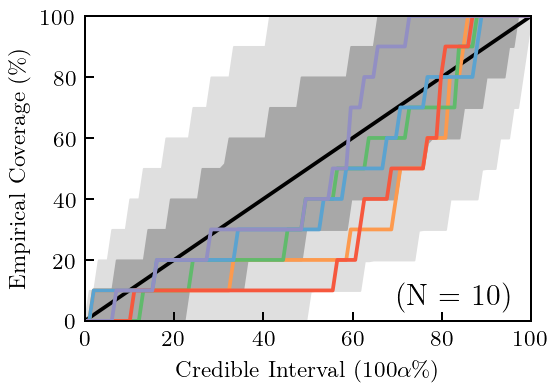

In [9]:
generate_diagnostics(
#     nn_interaction="np",
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["AY"],
#     E_input_array=[],
#     deg_input_array=[60],
    x_quantities_array = [[], [60]],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["Elab"]],
    train_test_split_array=[Allenergysplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    # length_scale_input=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
    LengthScale_list = [LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
    fixed_sd=None,
    m_pi_eff=186,
    Lambdab=610,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=False,
    save_md_bool=False,
    save_pc_bool=False,
    save_ci_bool=False,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_paper_0",
)

#### Figs. 15, 27b

[[], [60]]
[None, [60]]
[[None 60]]
E_lab = [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 23

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:664: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optima = np.array(optima)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
c:\users\pjmil\research\modern_nn_potentials\cheftgp\gaussianprocess.py:1595: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.shape(np.array(self.x_quantity_array)[
c:\users\pjmil\research\modern_nn_potentials\cheftgp\gaussianprocess.py:

self.ls_true = [71.71314357]
self.X_test has shape (10, 1)
self.underlying_std = 0.4891449177214713
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)


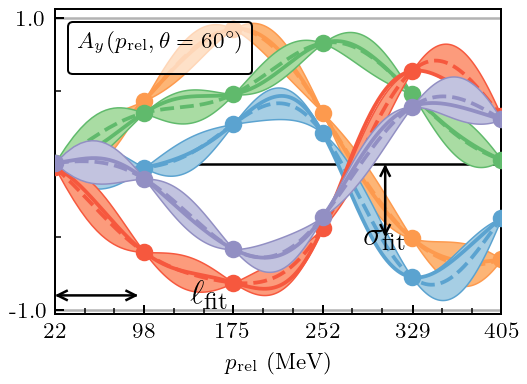

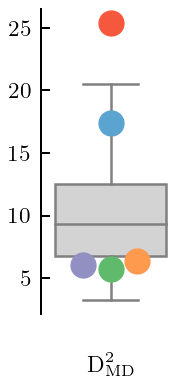

c:\users\pjmil\research\modern_nn_potentials\cheftgp\gaussianprocess.py:1790: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.shape(np.array(self.x_quantity_array)[


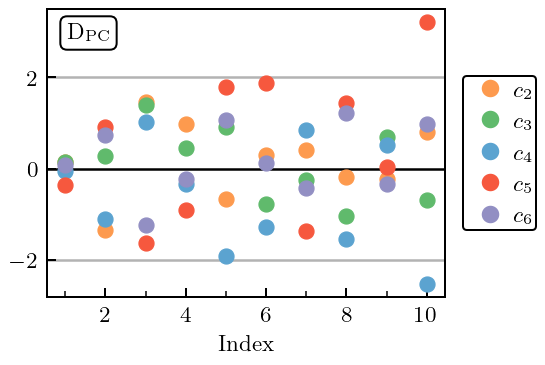

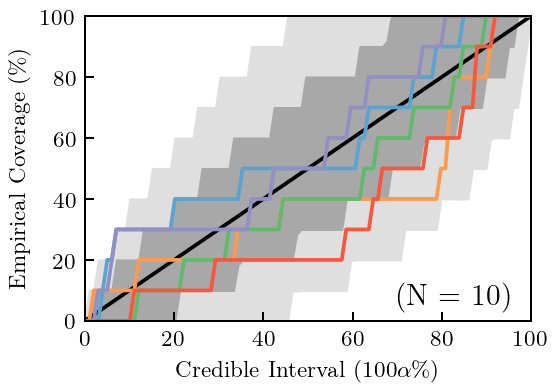

In [10]:
generate_diagnostics(
#     nn_interaction="np",
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["AY"],
#     E_input_array=[],
#     deg_input_array=[60],
    x_quantities_array = [[], [60]],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["prel"]],
    train_test_split_array=[Allenergysplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
#     LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
    fixed_sd=None,
    m_pi_eff=138,
    Lambdab=570,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=False,
    save_md_bool=False,
    save_pc_bool=False,
    save_ci_bool=False,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_paper_0",
)

#### Fig. 17

[[], [90]]
[None, [90]]
[[None 90]]
E_lab = [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 23

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:664: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optima = np.array(optima)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


self.ls_true = [84.22744191]
self.X_test has shape (10, 1)
self.underlying_std = 0.6345713637232866
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)


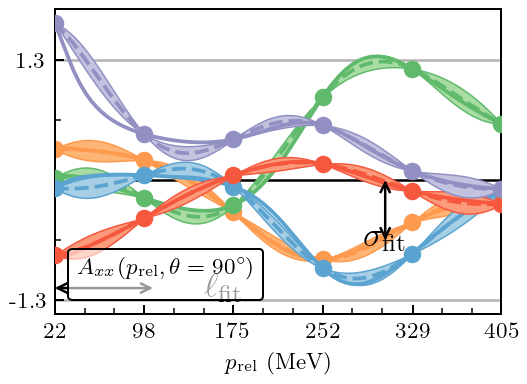

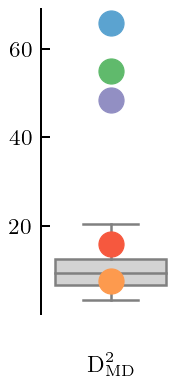

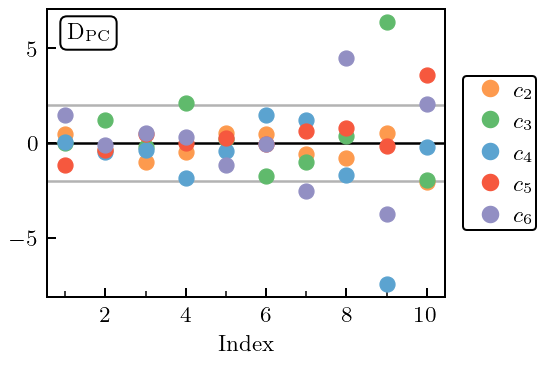

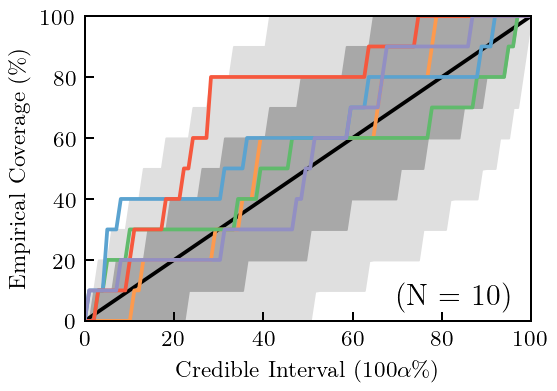

In [11]:
generate_diagnostics(
#     nn_interaction="np",
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["AXX"],
#     E_input_array=[],
#     deg_input_array=[90],
    x_quantities_array = [[], [90]],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["prel"]],
    train_test_split_array=[Allenergysplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
#     LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
    fixed_sd=None,
    m_pi_eff=138,
    Lambdab=570,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=False,
    save_md_bool=False,
    save_pc_bool=False,
    save_ci_bool=False,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_paper_0",
)

#### Fig. 18

[[], [90]]
[None, [90]]
[[None 90]]
E_lab = [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 23

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:664: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optima = np.array(optima)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


self.ls_true = [71.75410081]
self.X_test has shape (9, 1)
self.underlying_std = 0.5603470907116342
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)
(350,)


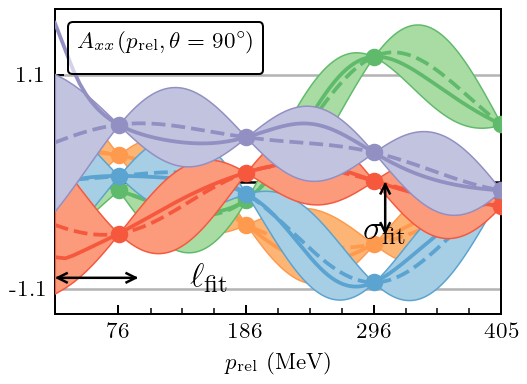

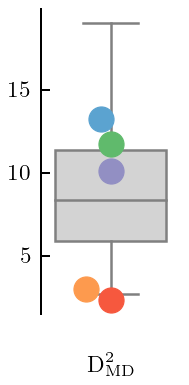

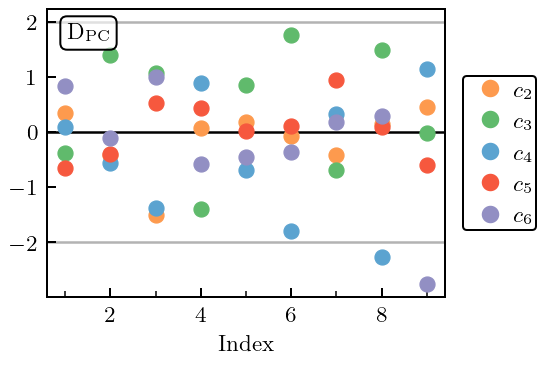

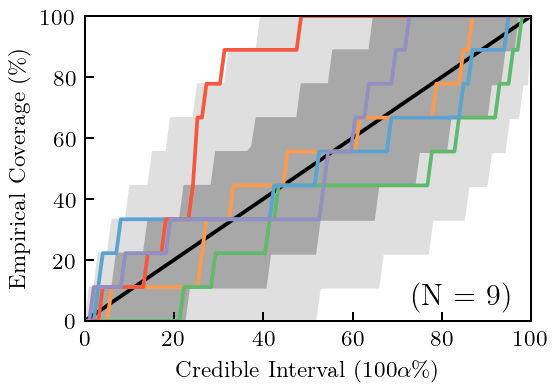

In [12]:
generate_diagnostics(
#     nn_interaction="np",
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["AXX"],
#     E_input_array=[],
#     deg_input_array=[90],
    x_quantities_array = [[], [90]],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["prel"]],
    train_test_split_array=[Nolowenergysplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
#     LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
    fixed_sd=None,
    m_pi_eff=138,
    Lambdab=570,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=False,
    save_md_bool=False,
    save_pc_bool=False,
    save_ci_bool=False,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_paper_0",
)

#### Fig. 19

[[50], []]
[[50], None]
[[50 None]]
E_lab = [50]
angle_lab = [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179]
['$', 'A', '(-\\mathrm{cos}(\\theta), E_{\\mathrm{lab}}= ', 50, '\\,\\mathrm{MeV})$']
(179,)
[-9.99847695e-01 -9.99390827e-01 -9.98629535e-01 -9.97564050e-01
 -9.96194698e-01 -9.94521895e-01 -9.92546152e-01 -9.90

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:664: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optima = np.array(optima)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
c:\users\pjmil\research\modern_nn_potentials\cheftgp\gaussianprocess.py:1595: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.shape(np.array(self.x_quantity_array)[
c:\users\pjmil\research\modern_nn_potentials\cheftgp\gaussianprocess.py:

self.ls_true = [0.51396768]
self.X_test has shape (10, 1)
self.underlying_std = 0.4712365893662049
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179,)
(179, 1)
(1, 1)
(1,)


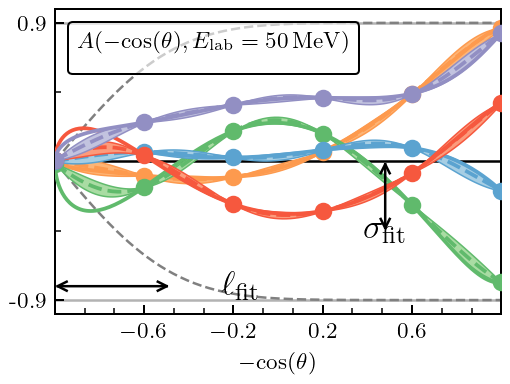

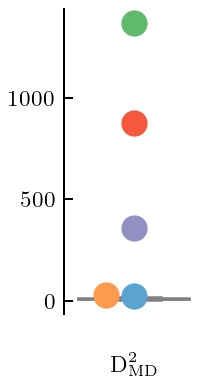

c:\users\pjmil\research\modern_nn_potentials\cheftgp\gaussianprocess.py:1790: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.shape(np.array(self.x_quantity_array)[


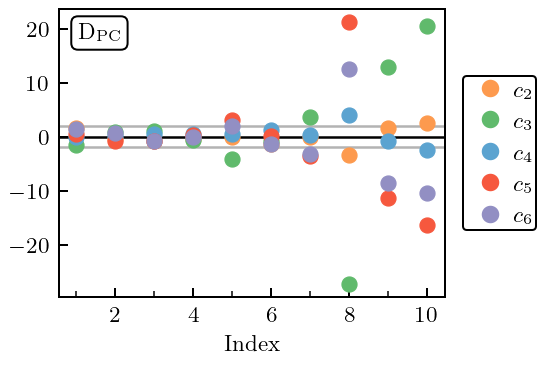

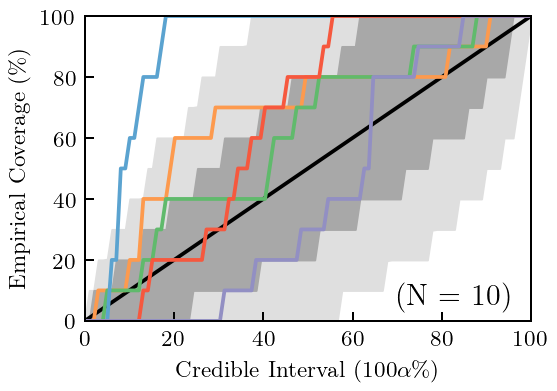

In [13]:
generate_diagnostics(
#     nn_interaction="np",
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["A"],
#     E_input_array=[50],
#     deg_input_array=[],
    x_quantities_array = [[50], []],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["cos"]],
    train_test_split_array=[Fullspaceanglessplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
#     LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
    fixed_sd=None,
    m_pi_eff=138,
    Lambdab=570,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=False,
    save_md_bool=False,
    save_pc_bool=False,
    save_ci_bool=False,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_paper_0",
)

#### Fig. 20

In [ ]:
generate_diagnostics(
#     nn_interaction="np",
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["A"],
#     E_input_array=[50],
#     deg_input_array=[],
    x_quantities_array = [[50], []],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["cos"]],
    train_test_split_array=[Backwardanglessplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
#     LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
    fixed_sd=None,
    m_pi_eff=138,
    Lambdab=570,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=False,
    save_md_bool=False,
    save_pc_bool=False,
    save_ci_bool=False,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_paper_0",
)

#### Fig. 21

In [ ]:
generate_diagnostics(
#     nn_interaction="np",
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["A"],
#     E_input_array=[50],
#     deg_input_array=[],
    x_quantities_array = [[50], []],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["deg"]],
    train_test_split_array=[Fullspaceanglessplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
#     LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
    fixed_sd=None,
    m_pi_eff=144,
    Lambdab=590,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=False,
    save_md_bool=False,
    save_pc_bool=False,
    save_ci_bool=False,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_paper_0",
)

#### Fig. 29

In [ ]:
generate_diagnostics(
#     nn_interaction="np",
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["AY"],
#     E_input_array=[200],
#     deg_input_array=[],
    x_quantities_array = [[200], []],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["cos"]],
    train_test_split_array=[Fullspaceanglessplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
#     LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
    fixed_sd=None,
    m_pi_eff=138,
    Lambdab=570,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=False,
    save_md_bool=False,
    save_pc_bool=False,
    save_ci_bool=False,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_paper_0",
)

#### Fig. 30

In [ ]:
generate_diagnostics(
#     nn_interaction="np",
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["AY"],
#     E_input_array=[200],
#     deg_input_array=[],
    x_quantities_array = [[200], []],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["cos"]],
    train_test_split_array=[Middleanglessplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
#     LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
    fixed_sd=None,
    m_pi_eff=138,
    Lambdab=570,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=False,
    save_md_bool=False,
    save_pc_bool=False,
    save_ci_bool=False,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_paper_0",
)

#### Fig. 31

In [ ]:
generate_diagnostics(
#     nn_interaction="np",
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["AY"],
#     E_input_array=[200],
#     deg_input_array=[],
    x_quantities_array = [[200], []],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["deg"]],
    train_test_split_array=[Fullspaceanglessplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
#     LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
    fixed_sd=None,
    m_pi_eff=144,
    Lambdab=590,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=False,
    save_md_bool=False,
    save_pc_bool=False,
    save_ci_bool=False,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_paper_0",
)

#### Fig. 22

In [ ]:
generate_diagnostics(
#     nn_interaction="np",
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["D_dimensionful"],
#     E_input_array=[100],
#     deg_input_array=[],
    x_quantities_array = [[100], []],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["cos"]],
    train_test_split_array=[Fullspaceanglessplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
#     LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
    fixed_sd=None,
    m_pi_eff=138,
    Lambdab=570,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=False,
    save_md_bool=False,
    save_pc_bool=False,
    save_ci_bool=False,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_paper_0_badref",
)

#### Fig. 23

In [ ]:
generate_diagnostics(
#     nn_interaction="np",
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["D"],
#     E_input_array=[100],
#     deg_input_array=[],
    x_quantities_array = [[100], []],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["cos"]],
    train_test_split_array=[Fullspaceanglessplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
#     LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
    fixed_sd=None,
    m_pi_eff=138,
    Lambdab=570,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=False,
    save_md_bool=False,
    save_pc_bool=False,
    save_ci_bool=False,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_paper_0",
)

#### Fig. 32

In [ ]:
generate_diagnostics(
#     nn_interaction="np",
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["D"],
#     E_input_array=[50],
#     deg_input_array=[],
    x_quantities_array = [[50], []],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["cos"]],
    train_test_split_array=[Fullspaceanglessplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
#     LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
    fixed_sd=None,
    m_pi_eff=138,
    Lambdab=570,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=False,
    save_md_bool=False,
    save_pc_bool=False,
    save_ci_bool=False,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_paper_0",
)

#### Fig. 33

In [ ]:
generate_diagnostics(
#     nn_interaction="np",
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["AXX"],
#     E_input_array=[150],
#     deg_input_array=[],
    x_quantities_array = [[150], []],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["cos"]],
    train_test_split_array=[Fullspaceanglessplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
#     LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
    fixed_sd=None,
    m_pi_eff=138,
    Lambdab=570,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=False,
    save_md_bool=False,
    save_pc_bool=False,
    save_ci_bool=False,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_paper_0",
)

#### Fig. 24

In [ ]:
generate_diagnostics(
#     nn_interaction="np",
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["AYY"],
#     E_input_array=[50],
#     deg_input_array=[],
    x_quantities_array = [[50], []],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["cos"]],
    train_test_split_array=[Fullspaceanglessplit1],
    orders_excluded=[],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
#     LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
    fixed_sd=None,
    m_pi_eff=138,
    Lambdab=570,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=False,
    save_md_bool=False,
    save_pc_bool=False,
    save_ci_bool=False,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_paper_0",
)

#### Fig. 25

In [ ]:
generate_diagnostics(
#     nn_interaction="np",
    scale_scheme_bunch_array=[RKE500MeV],
    observable_input=["AYY"],
#     E_input_array=[50],
#     deg_input_array=[],
    x_quantities_array = [[50], []],
    Q_param_method_array=["sum"],
    p_param_method_array=["Qofprel"],
    input_space_input=[["cos"]],
    train_test_split_array=[Fullspaceanglessplit1],
    orders_excluded=[6],
    orders_names_dict=None,
    orders_labels_dict=None,
    LengthScale_list=[LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True)],
#     LengthScaleTlabInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
#     LengthScaleDegInput=LengthScale("1/16-1_fitted", 0.25, 0.25, 4, whether_fit=True),
    fixed_sd=None,
    m_pi_eff=120,
    Lambdab=528,
    print_all_classes=False,
    savefile_type="png",
    plot_coeffs_bool=True,
    plot_md_bool=True,
    plot_pc_bool=True,
    plot_ci_bool=True,
    plot_pdf_bool=False,
    plot_trunc_bool=False,
    plot_plotzilla_bool=False,
    save_coeffs_bool=False,
    save_md_bool=False,
    save_pc_bool=False,
    save_ci_bool=False,
    save_pdf_bool=False,
    save_trunc_bool=False,
    save_plotzilla_bool=False,
    filename_addendum="_paper_0_noc6",
)

#### Fig. 9

In [ ]:
# create figure with n_orders subplots
fig_tlab_var_all_ratio, axs_tlab_var_all_ratio = plt.subplots(1, 1, 
                                                              figsize=(3.5,3.5))
axs_tlab_var_all_ratio.semilogy()

In [ ]:
# sets the potential of interest
ScaleScheme = RKE500MeV

# choose energy and angle meshes
t_lab = ScaleScheme.get_data("t_lab")

t_lab_input = E_to_p(E_lab = t_lab, interaction = "np")
# X_train_tlab = E_to_p(E_lab = np.array([5, 21, 48, 85, 133, 192, 261]), 
#                      interaction = "np")[:, None]
# X_train_tlab = E_to_p(E_lab = np.array([1, 12, 33, 65, 108, 161, 225, 300]), 
#                      interaction = "np")[:, None]
X_train_tlab = E_to_p(E_lab = np.array([1, 5, 12, 21, 33, 48, 65, 85, 108, 133, 161, 192, 225, 261, 300, 341]), 
                     interaction = "np")[:, None]
t_lab_label = "Relative momentum (MeV)"
# t_lab_input = t_lab
# X_train_tlab = np.array([5, 21, 48, 85, 133, 192, 261])[:, None]
# t_lab_label = "Lab energy (MeV)"

X_tlab = t_lab_input[:, None]
# t_lab_subset = t_lab_input[0::10]
t_lab_subset = X_train_tlab[:, 0]

degrees = ScaleScheme.get_data("degrees")

# degrees_input = degrees
# X_train_deg = np.array([1, 30, 60, 90, 120, 150, 179])[:, None]
# degrees_label = "Scattering angle (degrees)"
degrees_input = -np.cos(np.radians(degrees))
# X_train_deg = -np.cos(np.radians(np.array([1, 30, 60, 90, 120, 150, 179])))[:, None]
X_train_deg = -np.cos(np.radians(np.array([41, 60, 76, 90, 104, 120, 139])))[:, None]
degrees_label = "Negative cosine"

X_deg = degrees_input[:, None]
# degrees_subset = degrees_input[0::10]
degrees_subset = X_train_deg[:, 0]

Lambda_b_coeffs = 780
mpi_eff_coeffs = 240
# Lambda_b_coeffs = 570
# mpi_eff_coeffs = 138

# calculates ratio
p_type = "pprel"
p_grid = p_approx(p_name = p_type, 
                 prel = E_to_p(E_lab = t_lab, interaction = "np"), 
                 degrees = degrees).T
Q_type = "sum"
ratio = Q_approx(p = p_grid, 
                 Q_parametrization = Q_type, 
                 Lambda_b = Lambda_b_coeffs, 
                 m_pi = mpi_eff_coeffs,
                 single_expansion=False)

In [ ]:
axs_tlab_var_all_array = np.array([])

# extracts data
obs_data_name_list = ["DSG", "D", "AXX", "AYY", "A", "PB"]
obs_data_label_list = [r"$\frac{d \sigma}{d \Omega}$", 
                       r"$D$", r"$A_{xx}$", r"$A_{yy}$", r"$A$", r"$A_{y}$"]

for idx, obs_data_name in enumerate(obs_data_name_list):
    obs_data = ScaleScheme.get_data(obs_data_name)
    
    # sets reference scale
    if obs_data_name == "DSG":
        yref = obs_data[-1, :, :]
    else:
        yref = np.ones(np.shape(obs_data)[1:])

    # extracts coefficients
    coeffs_flattened = gm.coefficients(
                np.reshape(obs_data, (np.shape(obs_data)[0], np.shape(obs_data)[1] * np.shape(obs_data)[2])).T, 
                ratio=np.reshape(ratio, np.shape(ratio)[0] * np.shape(ratio)[1]),
                ref=np.reshape(yref, np.shape(yref)[0] * np.shape(yref)[1]), 
                orders=ScaleScheme.orders_full)
    coeffs_surfaces = np.reshape(coeffs_flattened.T, np.shape(obs_data))

#     axs_tlab_var_all_array = np.array([])

    # plots at each energy in mesh
    for t in t_lab_subset:
        gp = gm.ConjugateGaussianProcess(
            RBF(length_scale=0.25 * (np.max(degrees_input) - np.min(degrees_input)),
                          length_scale_bounds=(0.05 * (np.max(degrees_input) - np.min(degrees_input)), 
                                               2 * (np.max(degrees_input) - np.min(degrees_input)))
                   ) + WhiteKernel(1e-5, noise_level_bounds='fixed'), 
            center=0, 
            disp=0, 
            df=1,
            scale=1, 
            n_restarts_optimizer=100, 
            random_state=None,
            sd=None)
        gp.fit(X_train_deg, 
               np.reshape(coeffs_surfaces[:, np.isin(t_lab_input, t), :].T, 
                          (len(degrees), 
                           np.shape(coeffs_surfaces)[0]))[np.isin(degrees_input, X_train_deg), :])
        pred, std = gp.predict(X_deg, return_std=True)
        underlying_std = gp.cov_factor_
#         axs_tlab_var_all.scatter(t, 
#                     underlying_std, 
#     #                 c = 'green')
#                     c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t))
        axs_tlab_var_all_array = np.append(axs_tlab_var_all_array, underlying_std)
        
axs_tlab_var_all_array = np.reshape(axs_tlab_var_all_array, 
                                    (len(obs_data_name_list), len(t_lab_subset)))

In [ ]:
axs_tlab_var_all_ratio.scatter(list(range(len(obs_data_name_list))), 
    [np.max(axs_tlab_var_all_array[l, :]) / np.min(axs_tlab_var_all_array[l, :]) for l in range(len(axs_tlab_var_all_array))], 
    marker = 'o', 
    edgecolors = 'red',
    label = r'$Q_{\mathrm{sum}}(p_{\mathrm{rel}} \geq 25\,\mathrm{MeV}, m_{\pi}^{\star}, \Lambda_{b}^{\star})$',
#     edgecolors = 'green', 
#     label = r'2D ALLOBS, all $p_{\mathrm{rel}} > 25\,\mathrm{MeV}$',
    linewidths = 2,
    s = 90, 
    facecolors = 'none')
# axs_tlab_var_all_ratio.scatter(list(range(len(obs_data_name_list))), 
#     [np.max(axs_tlab_var_all_array[l, 4:]) / np.min(axs_tlab_var_all_array[l, 4:]) for l in range(len(axs_tlab_var_all_array))], 
#     marker = 's', 
# #     c = 'red', 
# #     label = r'OPAAT, $p_{\mathrm{rel}} > 125\,\mathrm{MeV}$', 
#     c = 'green', 
#     label = r'$Q_{\mathrm{sum}}(p_{\mathrm{rel}} \geq 125\,\mathrm{MeV}, m_{\pi}^{\prime}, \Lambda_{b}^{\prime})$',
#     s = 90)
# axs_tlab_var_all_ratio.legend(loc = 'upper right', 
#                               fontsize = 10,
#                               handletextpad=0.02,
#                               borderpad=0.2)

# axs_tlab_var_all_ratio.set_xticklabels([""] + obs_data_label_list + [""], fontsize = 10)
# axs_tlab_var_all_ratio.tick_params(axis = 'y', labelsize = 10)
# axs_tlab_var_all_ratio.set_xlim(-1, len(obs_data_name_list))
# axs_tlab_var_all_ratio.set_ylim(0.9, 160)

# axs_tlab_var_all.axhspan(0, np.min(axs_tlab_var_all_array[4:-2]), alpha=0.2, color='green')
# axs_tlab_var_all.axhspan(np.max(axs_tlab_var_all_array[4:-2]), 4, alpha=0.2, color='green')

# saves figures
# fig_tlab_var_all_ratio.savefig('figures/' + "var_ratios")

In [ ]:
Lambda_b_coeffs = 570
mpi_eff_coeffs = 138

# calculates ratio
p_type = "pprel"
p_grid = p_approx(p_name = p_type, 
                 prel = E_to_p(E_lab = t_lab, interaction = "np"), 
                 degrees = degrees).T
Q_type = "sum"
ratio = Q_approx(p = p_grid, 
                 Q_parametrization = Q_type, 
                 Lambda_b = Lambda_b_coeffs, 
                 m_pi = mpi_eff_coeffs,
                 single_expansion=False)

In [ ]:
axs_tlab_var_all_array = np.array([])

# extracts data
obs_data_name_list = ["DSG", "D", "AXX", "AYY", "A", "PB"]
obs_data_label_list = [r"$\frac{d \sigma}{d \Omega}$", 
                       r"$D$", r"$A_{xx}$", r"$A_{yy}$", r"$A$", r"$A_{y}$"]

for idx, obs_data_name in enumerate(obs_data_name_list):
    obs_data = ScaleScheme.get_data(obs_data_name)
    
    # sets reference scale
    if obs_data_name == "DSG":
        yref = obs_data[-1, :, :]
    else:
        yref = np.ones(np.shape(obs_data)[1:])

    # extracts coefficients
    coeffs_flattened = gm.coefficients(
                np.reshape(obs_data, (np.shape(obs_data)[0], np.shape(obs_data)[1] * np.shape(obs_data)[2])).T, 
                ratio=np.reshape(ratio, np.shape(ratio)[0] * np.shape(ratio)[1]),
                ref=np.reshape(yref, np.shape(yref)[0] * np.shape(yref)[1]), 
                orders=ScaleScheme.orders_full)
    coeffs_surfaces = np.reshape(coeffs_flattened.T, np.shape(obs_data))

#     axs_tlab_var_all_array = np.array([])

    # plots at each energy in mesh
    for t in t_lab_subset:
        gp = gm.ConjugateGaussianProcess(
            RBF(length_scale=0.25 * (np.max(degrees_input) - np.min(degrees_input)),
                          length_scale_bounds=(0.05 * (np.max(degrees_input) - np.min(degrees_input)), 
                                               2 * (np.max(degrees_input) - np.min(degrees_input)))
                   ) + WhiteKernel(1e-5, noise_level_bounds='fixed'), 
            center=0, 
            disp=0, 
            df=1,
            scale=1, 
            n_restarts_optimizer=100, 
            random_state=None,
            sd=None)
        gp.fit(X_train_deg, 
               np.reshape(coeffs_surfaces[:, np.isin(t_lab_input, t), :].T, 
                          (len(degrees), 
                           np.shape(coeffs_surfaces)[0]))[np.isin(degrees_input, X_train_deg), :])
        pred, std = gp.predict(X_deg, return_std=True)
        underlying_std = gp.cov_factor_
#         axs_tlab_var_all.scatter(t, 
#                     underlying_std, 
#     #                 c = 'green')
#                     c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t))
        axs_tlab_var_all_array = np.append(axs_tlab_var_all_array, underlying_std)
        
axs_tlab_var_all_array = np.reshape(axs_tlab_var_all_array, 
                                    (len(obs_data_name_list), len(t_lab_subset)))

In [ ]:
axs_tlab_var_all_ratio.scatter(list(range(len(obs_data_name_list))), 
    [np.max(axs_tlab_var_all_array[l, 4:]) / np.min(axs_tlab_var_all_array[l, 4:]) for l in range(len(axs_tlab_var_all_array))], 
    marker = 's', 
#     c = 'red', 
#     label = r'OPAAT, $p_{\mathrm{rel}} > 125\,\mathrm{MeV}$', 
    c = 'green', 
    label = r'$Q_{\mathrm{sum}}(p_{\mathrm{rel}} \geq 125\,\mathrm{MeV}, m_{\pi}^{\prime}, \Lambda_{b}^{\prime})$',
    s = 90)

axs_tlab_var_all_ratio.legend(loc = 'upper right', 
                              fontsize = 10,
                              handletextpad=0.02,
                              borderpad=0.2)

axs_tlab_var_all_ratio.set_xticklabels([""] + obs_data_label_list + [""], fontsize = 10)
axs_tlab_var_all_ratio.tick_params(axis = 'y', labelsize = 10)
axs_tlab_var_all_ratio.set_xlim(-1, len(obs_data_name_list))
axs_tlab_var_all_ratio.set_ylim(0.9, 160)

# axs_tlab_var_all.axhspan(0, np.min(axs_tlab_var_all_array[4:-2]), alpha=0.2, color='green')
# axs_tlab_var_all.axhspan(np.max(axs_tlab_var_all_array[4:-2]), 4, alpha=0.2, color='green')

# saves figures
fig_tlab_var_all_ratio.savefig('figures/' + "var_ratios")